In [1]:
using Pkg;
Pkg.activate("../");

using PyCall;
pygui(:tk);

  Activating project at `D:\GitHub\book-dp1`


In [2]:
include("s_approx.jl")
using Distributions
m(x) = max(x, 0)  # Convenience function

function create_inventory_model(; β=0.98,     # discount factor
                                  K=40,       # maximum inventory
                                  c=0.2, κ=2, # cost paramters
                                  p=0.6)      # demand parameter
    ϕ(d) = (1 - p)^d * p        # demand pdf
    x_vals = collect(0:K)       # set of inventory levels
    return (; β, K, c, κ, p, ϕ, x_vals)
end

"The function B(x, a, v) = r(x, a) + β Σ_x′ v(x′) P(x, a, x′)."
function B(x, a, v, model; d_max=100)
    (; β, K, c, κ, p, ϕ, x_vals) = model
    revenue = sum(min(x, d) * ϕ(d) for d in 0:d_max) 
    current_profit = revenue - c * a - κ * (a > 0)
    next_value = sum(v[m(x - d) + a + 1] * ϕ(d) for d in 0:d_max)
    return current_profit + β * next_value
end

"The Bellman operator."
function T(v, model)
    (; β, K, c, κ, p, ϕ, x_vals) = model
    new_v = similar(v)
    for (x_idx, x) in enumerate(x_vals)
        Γx = 0:(K - x) 
        new_v[x_idx], _ = findmax(B(x, a, v, model) for a in Γx)
    end
    return new_v
end

"Get a v-greedy policy.  Returns a zero-based array."
function get_greedy(v, model)
    (; β, K, c, κ, p, ϕ, x_vals) = model
    σ_star = zero(x_vals)
    for (x_idx, x) in enumerate(x_vals)
        Γx = 0:(K - x) 
        _, a_idx = findmax(B(x, a, v, model) for a in Γx)
        σ_star[x_idx] = Γx[a_idx]
    end
    return σ_star
end

"Use successive_approx to get v_star and then compute greedy."
function solve_inventory_model(v_init, model)
    (; β, K, c, κ, p, ϕ, x_vals) = model
    v_star = successive_approx(v -> T(v, model), v_init)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star
end

# == Plots == # 

using PyPlot
using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering

# Create an instance of the model and solve it
model = create_inventory_model()
(; β, K, c, κ, p, ϕ, x_vals) = model
v_init = zeros(length(x_vals))
v_star, σ_star = solve_inventory_model(v_init, model)

"Simulate given the optimal policy."
function sim_inventories(ts_length=400, X_init=0)
    G = Geometric(p)
    X = zeros(Int32, ts_length)
    X[1] = X_init
    for t in 1:(ts_length-1)
        D = rand(G)
        X[t+1] = m(X[t] - D) + σ_star[X[t] + 1]
    end
    return X
end


function plot_vstar_and_opt_policy(; fontsize=16, 
                   figname="../figures/inventory_dp_vs.pdf",
                   savefig=false)
    fig, axes = plt.subplots(2, 1, figsize=(8, 6.5))

    ax = axes[1]
    ax.plot(0:K, v_star, label=L"v^*")
    ax.set_ylabel("value", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=false)

    ax = axes[2]
    ax.plot(0:K, σ_star, label=L"\sigma^*")
    ax.set_xlabel("inventory", fontsize=fontsize)
    ax.set_ylabel("optimal choice", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=false)
    plt.show()
    if savefig == true
        fig.savefig(figname)
    end
end

function plot_ts(; fontsize=16, 
                   figname="../figures/inventory_dp_ts.pdf",
                   savefig=false)
    X = sim_inventories()
    fig, ax = plt.subplots(figsize=(9, 5.5))
    ax.plot(X, label=L"X_t", alpha=0.7)
    ax.set_xlabel(L"t", fontsize=fontsize)
    ax.set_ylabel("inventory", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=false)
    ax.set_ylim(0, maximum(X)+4)
    plt.show()
    if savefig == true
        fig.savefig(figname)
    end
end


LoadError: SystemError: opening file "D:\\GitHub\\book-dp1\\juliabook\\s_approx.jl": No such file or directory

In [3]:
plot_vstar_and_opt_policy(savefig=true)

LoadError: UndefVarError: `plot_vstar_and_opt_policy` not defined

In [4]:
plot_ts(savefig=true)

LoadError: UndefVarError: `plot_ts` not defined

In [5]:
using QuantEcon, LinearAlgebra, IterTools

function create_savings_model(; R=1.01, β=0.98, γ=2.5,  
                                w_min=0.01, w_max=20.0, w_size=200,
                                ρ=0.9, ν=0.1, y_size=5)
    w_grid = LinRange(w_min, w_max, w_size)  
    mc = tauchen(y_size, ρ, ν)
    y_grid, Q = exp.(mc.state_values), mc.p
    return (; β, R, γ, w_grid, y_grid, Q)
end

"B(w, y, w′, v) = u(R*w + y - w′) + β Σ_y′ v(w′, y′) Q(y, y′)."
function B(i, j, k, v, model)
    (; β, R, γ, w_grid, y_grid, Q) = model
    w, y, w′ = w_grid[i], y_grid[j], w_grid[k]
    u(c) = c^(1-γ) / (1-γ)
    c = w + y - (w′ / R)
    @views value = c > 0 ? u(c) + β * dot(v[k, :], Q[j, :]) : -Inf
    return value
end

"The Bellman operator."
function T(v, model)
    w_idx, y_idx = (eachindex(g) for g in (model.w_grid, model.y_grid))
    v_new = similar(v)
    for (i, j) in product(w_idx, y_idx)
        v_new[i, j] = maximum(B(i, j, k, v, model) for k in w_idx)
    end
    return v_new
end

"The policy operator."
function T_σ(v, σ, model)
    w_idx, y_idx = (eachindex(g) for g in (model.w_grid, model.y_grid))
    v_new = similar(v)
    for (i, j) in product(w_idx, y_idx)
        v_new[i, j] = B(i, j, σ[i, j], v, model) 
    end
    return v_new
end




T_σ

In [6]:
include("finite_opt_saving_0.jl")

"Compute a v-greedy policy."
function get_greedy(v, model)
    w_idx, y_idx = (eachindex(g) for g in (model.w_grid, model.y_grid))
    σ = Matrix{Int32}(undef, length(w_idx), length(y_idx))
    for (i, j) in product(w_idx, y_idx)
        _, σ[i, j] = findmax(B(i, j, k, v, model) for k in w_idx)
    end
    return σ
end

"Get the value v_σ of policy σ."
function get_value(σ, model)
    # Unpack and set up
    (; β, R, γ, w_grid, y_grid, Q) = model
    w_idx, y_idx = (eachindex(g) for g in (w_grid, y_grid))
    wn, yn = length(w_idx), length(y_idx)
    n = wn * yn
    u(c) = c^(1-γ) / (1-γ)
    # Build P_σ and r_σ as multi-index arrays
    P_σ = zeros(wn, yn, wn, yn)
    r_σ = zeros(wn, yn)
    for (i, j) in product(w_idx, y_idx)
            w, y, w′ = w_grid[i], y_grid[j], w_grid[σ[i, j]]
            r_σ[i, j] = u(w + y - w′/R)
        for (i′, j′) in product(w_idx, y_idx)
            if i′ == σ[i, j]
                P_σ[i, j, i′, j′] = Q[j, j′]
            end
        end
    end
    # Reshape for matrix algebra
    P_σ = reshape(P_σ, n, n)
    r_σ = reshape(r_σ, n)
    # Apply matrix operations --- solve for the value of σ 
    v_σ = (I - β * P_σ) \ r_σ
    # Return as multi-index array
    return reshape(v_σ, wn, yn)
end




LoadError: SystemError: opening file "D:\\GitHub\\book-dp1\\juliabook\\finite_opt_saving_0.jl": No such file or directory

In [7]:
include("s_approx.jl")
include("finite_opt_saving_1.jl")

"Value function iteration routine."
function value_iteration(model, tol=1e-5)
    vz = zeros(length(model.w_grid), length(model.y_grid))
    v_star = successive_approx(v -> T(v, model), vz, tolerance=tol)
    return get_greedy(v_star, model)
end

"Howard policy iteration routine."
function policy_iteration(model)
    wn, yn = length(model.w_grid), length(model.y_grid)
    σ = ones(Int32, wn, yn)
    i, error = 0, 1.0
    while error > 0
        v_σ = get_value(σ, model)
        σ_new = get_greedy(v_σ, model)
        error = maximum(abs.(σ_new - σ))
        σ = σ_new
        i = i + 1
        println("Concluded loop $i with error $error.")
    end
    return σ
end

"Optimistic policy iteration routine."
function optimistic_policy_iteration(model; tolerance=1e-5, m=100)
    v = zeros(length(model.w_grid), length(model.y_grid))
    error = tolerance + 1
    while error > tolerance
        last_v = v
        σ = get_greedy(v, model)
        for i in 1:m
            v = T_σ(v, σ, model)
        end
        error = maximum(abs.(v - last_v))
    end
    return get_greedy(v, model)
end

# == Simulations and inequality measures == #

function simulate_wealth(m)

    model = create_savings_model()
    σ_star = optimistic_policy_iteration(model)
    (; β, R, γ, w_grid, y_grid, Q) = model

    # Simulate labor income (indices rather than grid values)
    mc = MarkovChain(Q)
    y_idx_series = simulate(mc, m)

    # Compute corresponding wealth time series
    w_idx_series = similar(y_idx_series)
    w_idx_series[1] = 1  # initial condition
    for t in 1:(m-1)
        i, j = w_idx_series[t], y_idx_series[t]
        w_idx_series[t+1] = σ_star[i, j]
    end
    w_series = w_grid[w_idx_series]

    return w_series
end

function lorenz(v)  # assumed sorted vector
    S = cumsum(v)  # cumulative sums: [v[1], v[1] + v[2], ... ]
    F = (1:length(v)) / length(v)
    L = S ./ S[end]
    return (; F, L) # returns named tuple
end

gini(v) = (2 * sum(i * y for (i,y) in enumerate(v))/sum(v)
           - (length(v) + 1))/length(v)



# == Plots == #

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering
fontsize=16

function plot_timing(; m_vals=collect(range(1, 600, step=10)),
                       savefig=false)
    model = create_savings_model(y_size=5)
    println("Running Howard policy iteration.")
    pi_time = @elapsed σ_pi = policy_iteration(model)
    println("PI completed in $pi_time seconds.")
    println("Running value function iteration.")
    vfi_time = @elapsed σ_vfi = value_iteration(model)
    println("VFI completed in $vfi_time seconds.")
    @assert σ_vfi == σ_pi "Warning: policies deviated."
    opi_times = []
    for m in m_vals
        println("Running optimistic policy iteration with m=$m.")
        opi_time = @elapsed σ_opi = optimistic_policy_iteration(model, m=m)
        @assert σ_opi == σ_pi "Warning: policies deviated."
        println("OPI with m=$m completed in $opi_time seconds.")
        push!(opi_times, opi_time)
    end
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(m_vals, fill(vfi_time, length(m_vals)), 
            lw=2, label="value function iteration")
    ax.plot(m_vals, fill(pi_time, length(m_vals)), 
            lw=2, label="Howard policy iteration")
    ax.plot(m_vals, opi_times, lw=2, label="optimistic policy iteration")
    ax.legend(fontsize=fontsize, frameon=false)
    ax.set_xlabel(L"m", fontsize=fontsize)
    ax.set_ylabel("time", fontsize=fontsize)
    plt.show()
    if savefig
        fig.savefig("../figures/finite_opt_saving_2_1.pdf")
    end
    return (pi_time, vfi_time, opi_times)
end

function plot_policy(; method="pi")
    model = create_savings_model()
    (; β, R, γ, w_grid, y_grid, Q) = model
    if method == "vfi"
        σ_star =  value_iteration(model) 
    elseif method == "pi"
        σ_star = policy_iteration(model) 
    else
        σ_star = optimistic_policy_iteration(model)
    end
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_grid, w_grid, "k--", label=L"45")
    ax.plot(w_grid, w_grid[σ_star[:, 1]], label=L"\sigma^*(\cdot, y_1)")
    ax.plot(w_grid, w_grid[σ_star[:, end]], label=L"\sigma^*(\cdot, y_N)")
    ax.legend(fontsize=fontsize)
    plt.show()
end


function plot_time_series(; m=2_000,
                           savefig=false, 
                           figname="../figures/finite_opt_saving_ts.pdf")

    w_series = simulate_wealth(m)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_series, label=L"w_t")
    ax.set_xlabel("time", fontsize=fontsize)
    ax.legend(fontsize=fontsize)
    plt.show()
    if savefig
        fig.savefig(figname)
    end
end

function plot_histogram(; m=1_000_000,
                           savefig=false, 
                           figname="../figures/finite_opt_saving_hist.pdf")

    w_series = simulate_wealth(m)
    g = round(gini(sort(w_series)), digits=2)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.hist(w_series, bins=40, density=true)
    ax.set_xlabel("wealth", fontsize=fontsize)
    ax.text(15, 0.4, "Gini = $g", fontsize=fontsize)
    plt.show()

    if savefig
        fig.savefig(figname)
    end
end

function plot_lorenz(; m=1_000_000,
                           savefig=false, 
                           figname="../figures/finite_opt_saving_lorenz.pdf")

    w_series = simulate_wealth(m)
    (; F, L) = lorenz(sort(w_series))

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(F, F, label="Lorenz curve, equality")
    ax.plot(F, L, label="Lorenz curve, wealth distribution")
    ax.legend()
    plt.show()

    if savefig
        fig.savefig(figname)
    end
end



LoadError: SystemError: opening file "D:\\GitHub\\book-dp1\\juliabook\\s_approx.jl": No such file or directory

In [8]:
plot_timing(savefig=true)

LoadError: UndefVarError: `plot_timing` not defined

In [9]:
plot_policy()

LoadError: UndefVarError: `plot_policy` not defined

In [10]:
plot_time_series(savefig=true)

LoadError: UndefVarError: `plot_time_series` not defined

In [11]:
plot_histogram(savefig=true)

LoadError: UndefVarError: `plot_histogram` not defined

In [12]:
plot_lorenz(savefig=true)

LoadError: UndefVarError: `plot_lorenz` not defined

In [13]:
using QuantEcon, LinearAlgebra, IterTools
include("s_approx.jl")

function create_investment_model(; 
        r=0.04,                              # Interest rate
        a_0=10.0, a_1=1.0,                   # Demand parameters
        γ=25.0, c=1.0,                       # Adjustment and unit cost 
        y_min=0.0, y_max=20.0, y_size=100,   # Grid for output
        ρ=0.9, ν=1.0,                        # AR(1) parameters
        z_size=25)                           # Grid size for shock
    β = 1/(1+r) 
    y_grid = LinRange(y_min, y_max, y_size)  
    mc = tauchen(y_size, ρ, ν)
    z_grid, Q = mc.state_values, mc.p
    return (; β, a_0, a_1, γ, c, y_grid, z_grid, Q)
end

"""
The aggregator B is given by 

    B(y, z, y′) = r(y, z, y′) + β Σ_z′ v(y′, z′) Q(z, z′)."

where 

    r(y, z, y′) := (a_0 - a_1 * y + z - c) y - γ * (y′ - y)^2

"""
function B(i, j, k, v, model)
    (; β, a_0, a_1, γ, c, y_grid, z_grid, Q) = model
    y, z, y′ = y_grid[i], z_grid[j], y_grid[k]
    r = (a_0 - a_1 * y + z - c) * y - γ * (y′ - y)^2
    return @views r + β * dot(v[k, :], Q[j, :]) 
end

"The policy operator."
function T_σ(v, σ, model)
    y_idx, z_idx = (eachindex(g) for g in (model.y_grid, model.z_grid))
    v_new = similar(v)
    for (i, j) in product(y_idx, z_idx)
        v_new[i, j] = B(i, j, σ[i, j], v, model) 
    end
    return v_new
end

"The Bellman operator."
function T(v, model)
    y_idx, z_idx = (eachindex(g) for g in (model.y_grid, model.z_grid))
    v_new = similar(v)
    for (i, j) in product(y_idx, z_idx)
        v_new[i, j] = maximum(B(i, j, k, v, model) for k in y_idx)
    end
    return v_new
end

"Compute a v-greedy policy."
function get_greedy(v, model)
    y_idx, z_idx = (eachindex(g) for g in (model.y_grid, model.z_grid))
    σ = Matrix{Int32}(undef, length(y_idx), length(z_idx))
    for (i, j) in product(y_idx, z_idx)
        _, σ[i, j] = findmax(B(i, j, k, v, model) for k in y_idx)
    end
    return σ
end

"Value function iteration routine."
function value_iteration(model; tol=1e-5)
    vz = zeros(length(model.y_grid), length(model.z_grid))
    v_star = successive_approx(v -> T(v, model), vz, tolerance=tol)
    return get_greedy(v_star, model)
end



"Get the value v_σ of policy σ."
function get_value(σ, model)
    # Unpack and set up
    (; β, a_0, a_1, γ, c, y_grid, z_grid, Q) = model
    yn, zn = length(y_grid), length(z_grid)
    n = yn * zn
    # Function to extract (i, j) from m = i + (j-1)*yn"
    single_to_multi(m) = (m-1)%yn + 1, div(m-1, yn) + 1
    # Allocate and create single index versions of P_σ and r_σ
    P_σ = zeros(n, n)
    r_σ = zeros(n)
    for m in 1:n
        i, j = single_to_multi(m)
        y, z, y′ = y_grid[i], z_grid[j], y_grid[σ[i, j]]
        r_σ[m] = (a_0 - a_1 * y + z - c) * y - γ * (y′ - y)^2
        for m′ in 1:n
            i′, j′ = single_to_multi(m′)
            if i′ == σ[i, j]
                P_σ[m, m′] = Q[j, j′]
            end
        end
    end
    # Solve for the value of σ 
    v_σ = (I - β * P_σ) \ r_σ
    # Return as multi-index array
    return reshape(v_σ, yn, zn)
end


"Howard policy iteration routine."
function policy_iteration(model)
    yn, zn = length(model.y_grid), length(model.z_grid)
    σ = ones(Int32, yn, zn)
    i, error = 0, 1.0
    while error > 0
        v_σ = get_value(σ, model)
        σ_new = get_greedy(v_σ, model)
        error = maximum(abs.(σ_new - σ))
        σ = σ_new
        i = i + 1
        println("Concluded loop $i with error $error.")
    end
    return σ
end

"Optimistic policy iteration routine."
function optimistic_policy_iteration(model; tol=1e-5, m=100)
    v = zeros(length(model.y_grid), length(model.z_grid))
    error = tol + 1
    while error > tol
        last_v = v
        σ = get_greedy(v, model)
        for i in 1:m
            v = T_σ(v, σ, model)
        end
        error = maximum(abs.(v - last_v))
    end
    return get_greedy(v, model)
end


# Plots

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering
fontsize=12

function plot_policy()
    model = create_investment_model()
    (; β, a_0, a_1, γ, c, y_grid, z_grid, Q) = model
    σ_star = optimistic_policy_iteration(model)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(y_grid, y_grid, "k--", label=L"45")
    ax.plot(y_grid, y_grid[σ_star[:, 1]], label=L"\sigma^*(\cdot, z_1)")
    ax.plot(y_grid, y_grid[σ_star[:, end]], label=L"\sigma^*(\cdot, z_N)")
    ax.legend(fontsize=fontsize)
    plt.show()
end

function plot_sim(; savefig=false, figname="../figures/finite_lq_1.pdf")
    ts_length = 200

    fig, axes = plt.subplots(4, 1, figsize=(9, 11.2))

    for (ax, γ) in zip(axes, (1, 10, 20, 30))
        model = create_investment_model(γ=γ)
        (; β, a_0, a_1, γ, c, y_grid, z_grid, Q) = model
        σ_star = optimistic_policy_iteration(model)
        mc = MarkovChain(Q, z_grid)

        z_sim_idx = simulate_indices(mc, ts_length)
        z_sim = z_grid[z_sim_idx]
        y_sim_idx = Vector{Int32}(undef, ts_length)
        y_1 = (a_0 - c + z_sim[1]) / (2 * a_1)
        y_sim_idx[1] = searchsortedfirst(y_grid, y_1)
        for t in 1:(ts_length-1)
            y_sim_idx[t+1] = σ_star[y_sim_idx[t], z_sim_idx[t]]
        end
        y_sim = y_grid[y_sim_idx]
        y_bar_sim = (a_0 .- c .+ z_sim) ./ (2 * a_1)

        ax.plot(1:ts_length, y_sim, label=L"Y_t")
        ax.plot(1:ts_length, y_bar_sim, label=L"\bar Y_t")
        ax.legend(fontsize=fontsize, frameon=false, loc="upper right")
        ax.set_ylabel("output", fontsize=fontsize)
        ax.set_ylim(1, 9)
        ax.set_title(L"\gamma = " * "$γ", fontsize=fontsize)
    end

    fig.tight_layout()
    plt.show()
    if savefig
        fig.savefig(figname)
    end
end


function plot_timing(; m_vals=collect(range(1, 600, step=10)),
                   savefig=false,
                   figname="../figures/finite_lq_time.pdf"
    )
    model = create_investment_model()
    #println("Running Howard policy iteration.")
    pi_time = @elapsed σ_pi = policy_iteration(model)
    #println("PI completed in $pi_time seconds.")
    println("Running value function iteration.")
    vfi_time = @elapsed σ_vfi = value_iteration(model, tol=1e-5)
    println("VFI completed in $vfi_time seconds.")
    #@assert σ_vfi == σ_pi "Warning: policies deviated."
    opi_times = []
    for m in m_vals
        println("Running optimistic policy iteration with m=$m.")
        opi_time = @elapsed σ_opi = 
            optimistic_policy_iteration(model, m=m, tol=1e-5)
        println("OPI with m=$m completed in $opi_time seconds.")
        #@assert σ_opi == σ_pi "Warning: policies deviated."
        push!(opi_times, opi_time)
    end
    fig, ax = plt.subplots(figsize=(9, 5.2))
    #ax.plot(m_vals, fill(pi_time, length(m_vals)), 
    #        lw=2, label="Howard policy iteration")
    ax.plot(m_vals, fill(vfi_time, length(m_vals)), 
            lw=2, label="value function iteration")
    ax.plot(m_vals, opi_times, lw=2, label="optimistic policy iteration")
    ax.legend(fontsize=fontsize, frameon=false)
    ax.set_xlabel(L"m", fontsize=fontsize)
    ax.set_ylabel("time", fontsize=fontsize)
    plt.show()
    if savefig
        fig.savefig(figname)
    end
    return (pi_time, vfi_time, opi_times)
end



LoadError: SystemError: opening file "D:\\GitHub\\book-dp1\\juliabook\\s_approx.jl": No such file or directory

In [14]:
plot_policy()

LoadError: UndefVarError: `plot_policy` not defined

In [15]:
plot_sim(savefig=true)

LoadError: UndefVarError: `plot_sim` not defined

In [16]:
plot_timing(savefig=true)

LoadError: UndefVarError: `plot_timing` not defined

In [17]:
using QuantEcon, LinearAlgebra, IterTools

function create_hiring_model(; 
        r=0.04,                              # Interest rate
        κ=1.0,                               # Adjustment cost 
        α=0.4,                               # Production parameter
        p=1.0, w=1.0,                        # Price and wage
        l_min=0.0, l_max=30.0, l_size=100,   # Grid for labor
        ρ=0.9, ν=0.4, b=1.0,                 # AR(1) parameters
        z_size=100)                          # Grid size for shock
    β = 1/(1+r) 
    l_grid = LinRange(l_min, l_max, l_size)  
    mc = tauchen(z_size, ρ, ν, b, 6)
    z_grid, Q = mc.state_values, mc.p
    return (; β, κ, α, p, w, l_grid, z_grid, Q)
end

"""
The aggregator B is given by 

    B(l, z, l′) = r(l, z, l′) + β Σ_z′ v(l′, z′) Q(z, z′)."

where 

    r(l, z, l′) := p * z * f(l) - w * l - κ 1{l != l′}

"""
function B(i, j, k, v, model)
    (; β, κ, α, p, w, l_grid, z_grid, Q) = model
    l, z, l′ = l_grid[i], z_grid[j], l_grid[k]
    r = p * z * l^α - w * l - κ * (l != l′)
    return @views r + β * dot(v[k, :], Q[j, :]) 
end


"The policy operator."
function T_σ(v, σ, model)
    l_idx, z_idx = (eachindex(g) for g in (model.l_grid, model.z_grid))
    v_new = similar(v)
    for (i, j) in product(l_idx, z_idx)
        v_new[i, j] = B(i, j, σ[i, j], v, model) 
    end
    return v_new
end

"Compute a v-greedy policy."
function get_greedy(v, model)
    (; β, κ, α, p, w, l_grid, z_grid, Q) = model
    l_idx, z_idx = (eachindex(g) for g in (model.l_grid, model.z_grid))
    σ = Matrix{Int32}(undef, length(l_idx), length(z_idx))
    for (i, j) in product(l_idx, z_idx)
        _, σ[i, j] = findmax(B(i, j, k, v, model) for k in l_idx)
    end
    return σ
end

"Optimistic policy iteration routine."
function optimistic_policy_iteration(model; tolerance=1e-5, m=100)
    v = zeros(length(model.l_grid), length(model.z_grid))
    error = tolerance + 1
    while error > tolerance
        last_v = v
        σ = get_greedy(v, model)
        for i in 1:m
            v = T_σ(v, σ, model)
        end
        error = maximum(abs.(v - last_v))
    end
    return get_greedy(v, model)
end


# Plots

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering
fontsize=14

function plot_policy(; savefig=false, 
                    figname="../figures/firm_hiring_pol.pdf")
    model = create_hiring_model()
    (; β, κ, α, p, w, l_grid, z_grid, Q) = model
    σ_star = optimistic_policy_iteration(model)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(l_grid, l_grid, "k--", label=L"45")
    ax.plot(l_grid, l_grid[σ_star[:, 1]], label=L"\sigma^*(\cdot, z_1)")
    ax.plot(l_grid, l_grid[σ_star[:, end]], label=L"\sigma^*(\cdot, z_N)")
    ax.legend(fontsize=fontsize)
    plt.show()
end


function sim_dynamics(model, ts_length)

    (; β, κ, α, p, w, l_grid, z_grid, Q) = model
    σ_star = optimistic_policy_iteration(model)
    mc = MarkovChain(Q, z_grid)
    z_sim_idx = simulate_indices(mc, ts_length)
    z_sim = z_grid[z_sim_idx]
    l_sim_idx = Vector{Int32}(undef, ts_length)
    l_sim_idx[1] = 32
    for t in 1:(ts_length-1)
        l_sim_idx[t+1] = σ_star[l_sim_idx[t], z_sim_idx[t]]
    end
    l_sim = l_grid[l_sim_idx]

    y_sim = similar(l_sim)
    for (i, l) in enumerate(l_sim)
        y_sim[i] = p * z_sim[i] * l_sim[i]^α
    end

    t = ts_length - 1
    l_g, y_g, z_g = zeros(t), zeros(t), zeros(t)

    for i in 1:t
        l_g[i] = (l_sim[i+1] - l_sim[i]) / l_sim[i]
        y_g[i] = (y_sim[i+1] - y_sim[i]) / y_sim[i]
        z_g[i] = (z_sim[i+1] - z_sim[i]) / z_sim[i]
    end

    return l_sim, y_sim, z_sim, l_g, y_g, z_g

end



function plot_sim(; savefig=false, 
                    figname="../figures/firm_hiring_ts.pdf",
                    ts_length = 250)

    model = create_hiring_model()
    (; β, κ, α, p, w, l_grid, z_grid, Q) = model
    l_sim, y_sim, z_sim, l_g, y_g, z_g = sim_dynamics(model, ts_length)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(1:ts_length, l_sim, label=L"\ell_t")
    ax.plot(1:ts_length, z_sim, alpha=0.6, label=L"Z_t")
    ax.legend(fontsize=fontsize, frameon=false)
    ax.set_ylabel("employment", fontsize=fontsize)
    ax.set_xlabel("time", fontsize=fontsize)

    plt.show()
    if savefig
        fig.savefig(figname)
    end
end


function plot_growth(; savefig=false, 
                    figname="../figures/firm_hiring_g.pdf",
                    ts_length = 10_000_000)

    model = create_hiring_model()
    (; β, κ, α, p, w, l_grid, z_grid, Q) = model
    l_sim, y_sim, z_sim, l_g, y_g, z_g = sim_dynamics(model, ts_length)

    fig, ax = plt.subplots()
    ax.hist(l_g, alpha=0.6, bins=100)
    ax.set_xlabel("growth", fontsize=fontsize)

    #fig, axes = plt.subplots(2, 1)
    #series = y_g, z_g
    #for (ax, g) in zip(axes, series)
    #    ax.hist(g, alpha=0.6, bins=100)
    #    ax.set_xlabel("growth", fontsize=fontsize)
    #end

    plt.tight_layout()
    plt.show()
    if savefig
        fig.savefig(figname)
    end
end


plot_growth (generic function with 1 method)

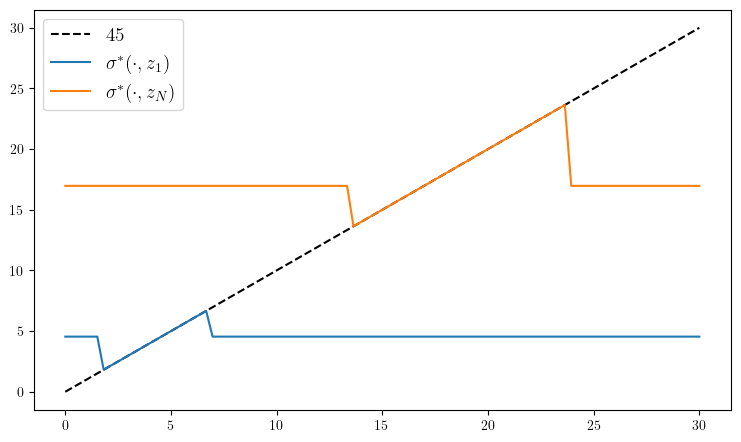

PyObject <matplotlib.legend.Legend object at 0x000002386B9CA200>

In [18]:
plot_policy()

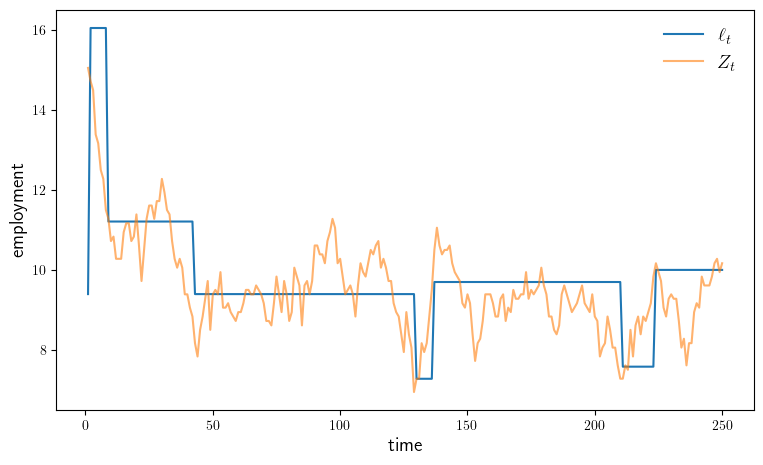

In [19]:
plot_sim(savefig=true)

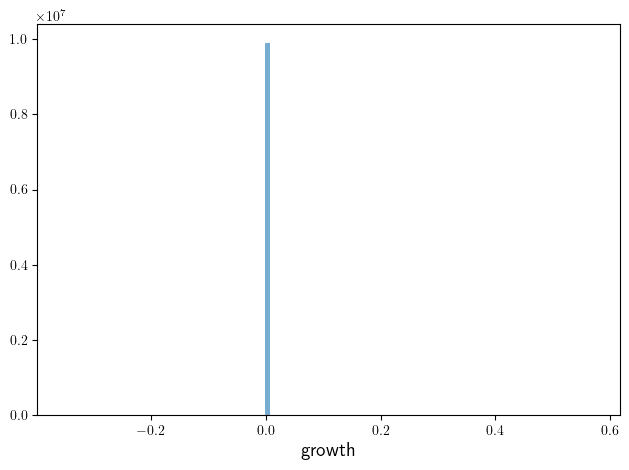

In [20]:
plot_growth(savefig=true)

In [21]:
using QuantEcon, LinearAlgebra, IterTools

function create_savings_model(; β=0.98, γ=2.5,  
                                w_min=0.01, w_max=20.0, w_size=100,
                                ρ=0.9, ν=0.1, y_size=20,
                                η_min=0.75, η_max=1.25, η_size=2)
    η_grid = LinRange(η_min, η_max, η_size)  
    ϕ = ones(η_size) * (1 / η_size)  # Uniform distributoin
    w_grid = LinRange(w_min, w_max, w_size)  
    mc = tauchen(y_size, ρ, ν)
    y_grid, Q = exp.(mc.state_values), mc.p
    return (; β, γ, η_grid, ϕ, w_grid, y_grid, Q)
end



## == Functions for regular OPI == ##

"""
B(w, y, η, w′) = u(w + y - w′/η)) + β Σ v(w′, y′, η′) Q(y, y′) ϕ(η′)
"""
function B(i, j, k, l, v, model)
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    w, y, η, w′ = w_grid[i], y_grid[j], η_grid[k], w_grid[l]
    u(c) = c^(1-γ)/(1-γ)
    c = w + y - (w′/ η)
    exp_value = 0.0
    for m in eachindex(y_grid)
        for n in eachindex(η_grid)
            exp_value += v[l, m, n] * Q[j, m] * ϕ[n]
        end
    end
    return c > 0 ? u(c) + β * exp_value : -Inf
end

"The policy operator."
function T_σ(v, σ, model)
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    grids = w_grid, y_grid, η_grid
    w_idx, y_idx, η_idx = (eachindex(g) for g in grids)
    v_new = similar(v)
    for (i, j, k) in product(w_idx, y_idx, η_idx)
        v_new[i, j, k] = B(i, j, k, σ[i, j, k], v, model) 
    end
    return v_new
end

"Compute a v-greedy policy."
function get_greedy(v, model)
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    w_idx, y_idx, η_idx = (eachindex(g) for g in (w_grid, y_grid, η_grid))
    σ = Array{Int32}(undef, length(w_idx), length(y_idx), length(η_idx))
    for (i, j, k) in product(w_idx, y_idx, η_idx)
        _, σ[i, j, k] = findmax(B(i, j, k, l, v, model) for l in w_idx)
    end
    return σ
end


"Optimistic policy iteration routine."
function optimistic_policy_iteration(model; tolerance=1e-5, m=100)
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    v = zeros(length(w_grid), length(y_grid), length(η_grid))
    error = tolerance + 1
    while error > tolerance
        last_v = v
        σ = get_greedy(v, model)
        for i in 1:m
            v = T_σ(v, σ, model)
        end
        error = maximum(abs.(v - last_v))
        println("OPI current error = $error")
    end
    return get_greedy(v, model)
end


## == Functions for modified OPI == ##

"D(w, y, η, w′, g) = u(w + y - w′/η) + β g(y, w′)."
@inline function D(i, j, k, l, g, model)
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    w, y, η, w′ = w_grid[i], y_grid[j], η_grid[k], w_grid[l]
    u(c) = c^(1-γ)/(1-γ)
    c = w + y - (w′/η)
    return c > 0 ? u(c) + β * g[j, l] : -Inf
end


"Compute a g-greedy policy."
function get_g_greedy(g, model)
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    w_idx, y_idx, η_idx = (eachindex(g) for g in (w_grid, y_grid, η_grid))
    σ = Array{Int32}(undef, length(w_idx), length(y_idx), length(η_idx))
    for (i, j, k) in product(w_idx, y_idx, η_idx)
        _, σ[i, j, k] = findmax(D(i, j, k, l, g, model) for l in w_idx)
    end
    return σ
end


"The modified policy operator."
function R_σ(g, σ, model)
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    w_idx, y_idx, η_idx = (eachindex(g) for g in (w_grid, y_grid, η_grid))
    g_new = similar(g)
    for (j, i′) in product(y_idx, w_idx)  # j indexes y, i′ indexes w′ 
        out = 0.0
        for j′ in y_idx                   # j′ indexes y′
            for k′ in η_idx               # k′ indexes η′
                out += D(i′, j′, k′, σ[i′, j′, k′], g, model) * 
                        Q[j, j′] * ϕ[k′]
            end
        end
        g_new[j, i′] = out
    end
    return g_new
end


"Modified optimistic policy iteration routine."
function mod_opi(model; tolerance=1e-5, m=100)
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    g = zeros(length(y_grid), length(w_grid))
    error = tolerance + 1
    while error > tolerance
        last_g = g
        σ = get_g_greedy(g, model)
        for i in 1:m
            g = R_σ(g, σ, model)
        end
        error = maximum(abs.(g - last_g))
        println("OPI current error = $error")
    end
    return get_g_greedy(g, model)
end


# == Simulations and inequality measures == #

function simulate_wealth(m)

    model = create_savings_model()
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    σ_star = mod_opi(model)

    # Simulate labor income
    mc = MarkovChain(Q)
    y_idx_series = simulate(mc, m)

    # IID Markov chain with uniform draws
    l = length(η_grid)
    mc = MarkovChain(ones(l, l) * (1/l))
    η_idx_series = simulate(mc, m)

    w_idx_series = similar(y_idx_series)
    w_idx_series[1] = 1
    for t in 1:(m-1)
        i, j, k = w_idx_series[t], y_idx_series[t], η_idx_series[t]
        w_idx_series[t+1] = σ_star[i, j, k]
    end

    w_series = w_grid[w_idx_series]
    return w_series
end


function lorenz(v)  # assumed sorted vector
    S = cumsum(v)  # cumulative sums: [v[1], v[1] + v[2], ... ]
    F = (1:length(v)) / length(v)
    L = S ./ S[end]
    return (; F, L) # returns named tuple
end


gini(v) = (2 * sum(i * y for (i,y) in enumerate(v))/sum(v)
           - (length(v) + 1))/length(v)


# == Plots == #

using PyPlot
using LaTeXStrings
PyPlot.matplotlib[:rc]("text", usetex=true) # allow tex rendering
fontsize=16



function plot_contours(; savefig=false, 
                         figname="../figures/modified_opt_savings_1.pdf")

    model = create_savings_model()
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    σ_star = optimistic_policy_iteration(model)

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    y_idx, η_idx = eachindex(y_grid), eachindex(η_grid)
    H = zeros(length(y_grid), length(η_grid))

    w_indices = (1, length(w_grid))
    titles = "low wealth", "high wealth"
    for (ax, w_idx, title) in zip(axes, w_indices, titles)

        for (i_y, i_ϵ) in product(y_idx, η_idx)
            w, y, η = w_grid[w_idx], y_grid[i_y], η_grid[i_ϵ]
            H[i_y, i_ϵ] = w_grid[σ_star[w_idx, i_y, i_ϵ]] / (w+y)
        end

        cs1 = ax.contourf(y_grid, η_grid, transpose(H), alpha=0.5)
        plt.colorbar(cs1, ax=ax) #, format="%.6f")

        ax.set_title(title, fontsize=fontsize)
        ax.set_xlabel(L"y", fontsize=fontsize)
        ax.set_ylabel(L"\varepsilon", fontsize=fontsize)
    end

    plt.tight_layout()
    if savefig
        fig.savefig(figname)
    end
    plt.show()
end


function plot_policies(; savefig=false, 
                         figname="../figures/modified_opt_savings_2.pdf")

    model = create_savings_model()
    (; β, γ, η_grid, ϕ, w_grid, y_grid, Q) = model
    σ_star = mod_opi(model)
    y_bar = floor(Int, length(y_grid) / 2)  # Index of mid-point of y_grid

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_grid, w_grid, "k--", label=L"45")

    for (i, η) in enumerate(η_grid)
        label = L"\sigma^*" * " at " * L"\eta = " * "$η"
        ax.plot(w_grid, w_grid[σ_star[:, y_bar, i]], label=label)
    end
    ax.legend(fontsize=fontsize)
    plt.show()

    plt.tight_layout()
    if savefig
        fig.savefig(figname)
    end
    plt.show()
end


function plot_time_series(; m=2_000,
                           savefig=false, 
                           figname="../figures/modified_opt_savings_ts.pdf")

    w_series = simulate_wealth(m)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(w_series, label=L"w_t")
    ax.legend(fontsize=fontsize)
    ax.set_xlabel("time", fontsize=fontsize)
    plt.show()
    if savefig
        fig.savefig(figname)
    end

end

function plot_histogram(; m=1_000_000,
                           savefig=false, 
                           figname="../figures/modified_opt_savings_hist.pdf")

    w_series = simulate_wealth(m)
    g = round(gini(sort(w_series)), digits=2)
    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.hist(w_series, bins=40, density=true)
    ax.set_xlabel("wealth", fontsize=fontsize)
    ax.text(15, 0.7, "Gini = $g", fontsize=fontsize)
    plt.show()
    if savefig
        fig.savefig(figname)
    end

end


function plot_lorenz(; m=1_000_000,
                           savefig=false, 
                           figname="../figures/modified_opt_savings_lorenz.pdf")

    w_series = simulate_wealth(m)
    (; F, L) = lorenz(sort(w_series))

    fig, ax = plt.subplots(figsize=(9, 5.2))
    ax.plot(F, F, label="Lorenz curve, equality")
    ax.plot(F, L, label="Lorenz curve, wealth distribution")
    ax.legend()
    plt.show()
    if savefig
        fig.savefig(figname)
    end

end




plot_lorenz (generic function with 1 method)

OPI current error = 38.399920491529734
OPI current error = 4.066951180848044


OPI current error = 4.6380954261438845
OPI current error = 1.3260813588221083


OPI current error = 0.38722029225052523
OPI current error = 0.09428546775951219


OPI current error = 0.02026455329022525
OPI current error = 0.002633073607984926


OPI current error = 0.00013614255682270482
OPI current error = 7.911990667963664e-6


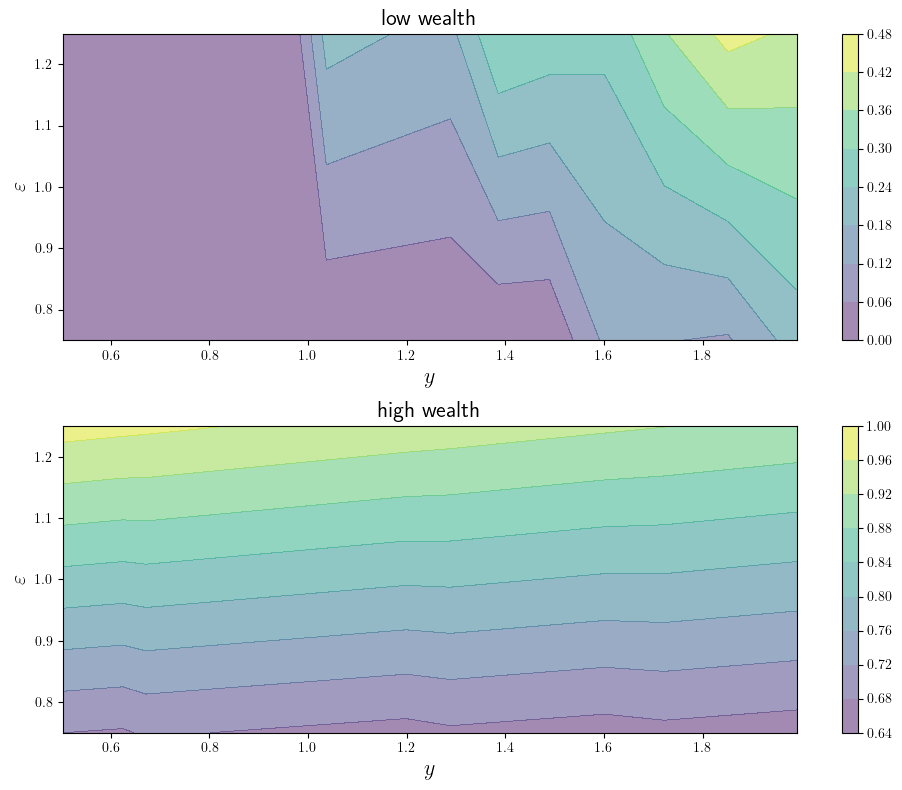

In [22]:
plot_contours(savefig=true)

OPI current error = 37.35040200118496


OPI current error = 4.066625094726078


OPI current error = 3.892585870289693


OPI current error = 1.1681955052615045


OPI current error = 0.3343174765677297


OPI current error = 0.06611271436991473


OPI current error = 0.010680300539267051


OPI current error = 0.0009714030350238545


OPI current error = 7.058042499252792e-5


OPI current error = 7.91199024874345e-6

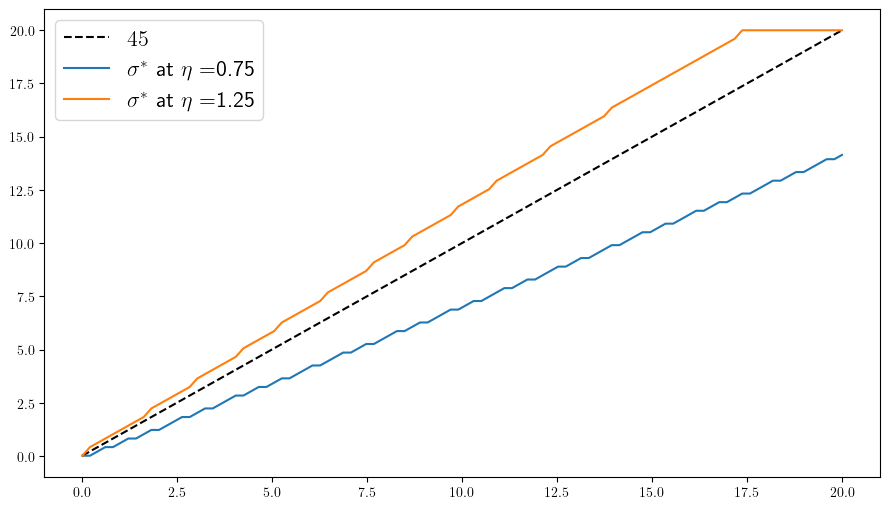

In [23]:
plot_policies(savefig=true)

OPI current error = 37.35040200118496


OPI current error = 4.066625094726078


OPI current error = 3.892585870289693


OPI current error = 1.1681955052615045


OPI current error = 0.3343174765677297


OPI current error = 0.06611271436991473


OPI current error = 0.010680300539267051


OPI current error = 0.0009714030350238545


OPI current error = 7.058042499252792e-5


OPI current error = 7.91199024874345e-6

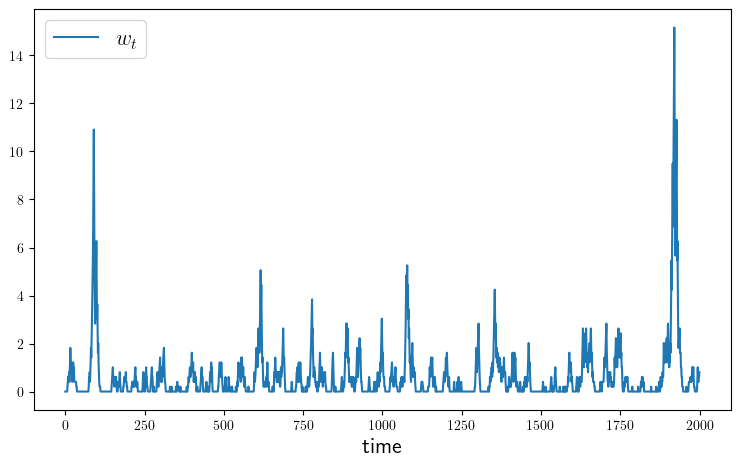

In [24]:
plot_time_series(savefig=true)

OPI current error = 37.35040200118496


OPI current error = 4.066625094726078


OPI current error = 3.892585870289693


OPI current error = 1.1681955052615045


OPI current error = 0.3343174765677297


OPI current error = 0.06611271436991473


OPI current error = 0.010680300539267051


OPI current error = 0.0009714030350238545


OPI current error = 7.058042499252792e-5


OPI current error = 7.91199024874345e-6

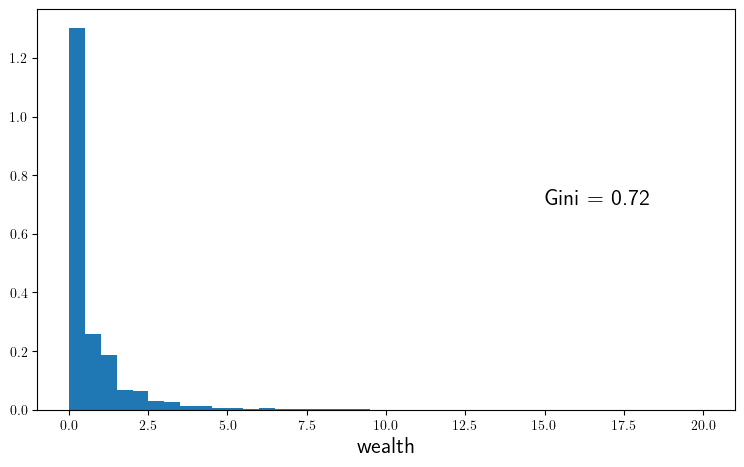

In [25]:
plot_histogram(savefig=true)

OPI current error = 37.35040200118496


OPI current error = 4.066625094726078


OPI current error = 3.892585870289693


OPI current error = 1.1681955052615045


OPI current error = 0.3343174765677297


OPI current error = 0.06611271436991473


OPI current error = 0.010680300539267051


OPI current error = 0.0009714030350238545


OPI current error = 7.058042499252792e-5


OPI current error = 7.91199024874345e-6

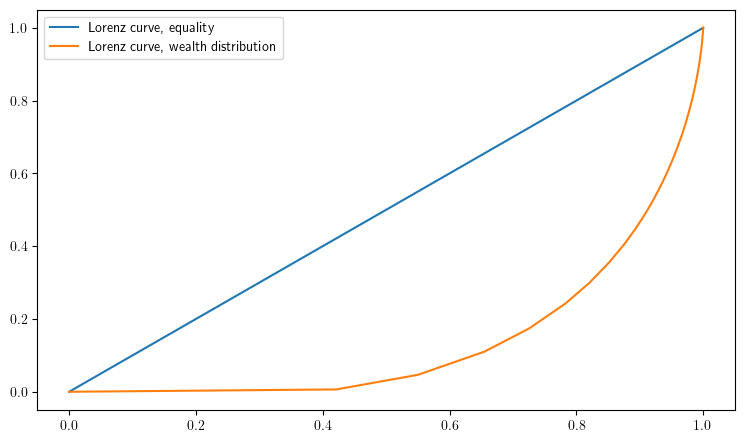

In [26]:
plot_lorenz(savefig=true)